# Import modules

In [2]:
import numpy as np
import importlib
import mdtraj as md
import MDAnalysis as mda
import pandas as pd
import pyemma
# Import visualization module for molecular visualization
from tools.visualization import Visualization
# Import descriptors module to obtain descriptors for triad molecule
from tools.descriptors import Descriptors
# Import plotting module for plotting
from tools import plotting
# Import module for clustering results inspection
from tools.clustering import Cluster_inspection

# Load files

In [4]:
file_dir = '/xspace/hl4212/DURF_datasets/triad_molecule'
traj_path = f'{file_dir}/triad_dataset.nc'
traj_path_aligned = f'{file_dir}/triad_dataset_aligned.nc'
top_path = f'{file_dir}/triad_forcefield_ground.prmtop'

# Data visualization

In [45]:
triad_viz = Visualization(traj_path_aligned, top_path)
triad_viz.ball_and_stick()

NGLWidget(max_frame=99999)

## Compare different conformations

In [110]:
triad_viz.compare(87288, 65044)

NGLWidget()

# Get descriptors

In [3]:
d = Descriptors(traj_path, top_path)
EuclidianDist_1 = d.eucdist('C33','C128')
Angle_1 = d.angle('C33','C96','C128')
Angle_2 = d.angle('C33','C69','C96')
Angle_3 = d.angle('C69','C96','C128')
Dihedral_1 = d.dihedral('C21','C61','C66','C65')
Dihedral_2 = d.dihedral('C89','N6','C95','C96')
# For the RMSD descriptor, choose the frame with the largest 'Angle_1' as linear, the smallest as bent
# The frame number for linear is 88213, for bent is 29685
RMSD_Linear = d.rmsd(frame = 88213)
RMSD_Bent = d.rmsd(frame = 29685)

In [5]:
# Visulize the descriptors in dataframe
d_DataFrame = d.to_df(EuclidianDist_1=EuclidianDist_1, Angle_1=Angle_1,\
                      Angle_2=Angle_2, Angle_3=Angle_3, Dihedral_1=Dihedral_1,\
                      Dihedral_2=Dihedral_2, RMSD_Linear =RMSD_Linear, RMSD_Bent =RMSD_Bent)
d_DataFrame

EuclidianDist_1    1.222519
Angle_1            0.356899
Angle_2            1.316854
Angle_3            1.178312
Dihedral_1         1.596905
Dihedral_2         3.021927
RMSD_Linear        1.464484
RMSD_Bent          0.000000
Name: 29685, dtype: float32

In [122]:
# Convert dataframe to nparray for dimensionality reduction and save it back to disk
dimreduct_results_dir = '/xspace/hl4212/results/dimensionality_reduction'
array_path = f'{dimreduct_results_dir}/dimreduct_descriptors_arr.npy'

In [67]:
d_array = np.array(d_DataFrame)
np.save(array_path, d_array)

In [9]:
pd.DataFrame(np.load('/xspace/hl4212/results/dimensionality_reduction/dimreduct_descriptors_arr.npy'),
            columns = ['EuclidianDist_1','Angle_1', 'Angle_2', 'Angle_3', 'Dihedral_1', 'Dihedral_2', 'RMSD_Linear', 'RMSD_Bent' ])

,EuclidianDist_1,Angle_1,Angle_2,Angle_3,Dihedral_1,Dihedral_2,RMSD_Linear,RMSD_Bent
0,4.135001,1.862408,2.174203,1.523234,2.619274,3.074855,0.763624,1.046674
1,4.081912,1.844877,2.225012,1.549974,2.698790,3.141504,0.768220,1.047367
2,4.078993,1.791105,2.345837,1.558566,2.680488,3.087373,0.775650,1.044716
3,4.120493,1.824511,2.289704,1.548207,2.608084,2.905645,0.767361,1.058475
4,4.074001,1.811295,2.226435,1.545865,2.526079,2.918643,0.784022,1.035676
...,...,...,...,...,...,...,...,...
99995,4.657602,2.134681,2.807392,2.029222,2.145249,3.141455,0.528814,1.204386
99996,4.543524,2.063565,2.831861,2.023469,1.931827,2.972840,0.557411,1.186918
99997,4.593875,2.089307,2.805922,1.997702,2.161717,2.770834,0.539554,1.194707
99998,4.625174,2.137845,2.851437,2.080499,1.990369,3.005851,0.501717,1.232133


# [Dimensionality reduction](Dimensionality_reduction.py) (Run on hpc)

## Algorithms used in the project & hyperparameters
- PCA
- kPCA
- kernel = poly, rbf
- t\-SNE, default setting
    - perlexity = 30
    - learning_rate = 200
    - init = random
- t\-SNE, hyperparameters tuned to the recommendation in [this paper](https://www.nature.com/articles/s41467-019-13056-x)
    - perplexity = 30
    - learning_rate = (size_of_data)//12
    - init = pca
- MDS is not used since the dataset is too large for the algorithm to run

## Dimreduct for coordinates
- Since hpc has no `mdtraj` module installed, first generate the traj xyz in 2D for the dimreduct program

In [40]:
# Load the original dataset for dim reduction of the coordinates
file_dir = '/xspace/hl4212/DURF_datasets/triad_molecule'
traj_path = f'{file_dir}/triad_dataset.nc'
top_path = f'{file_dir}/triad_forcefield_ground.prmtop'
traj = md.load(traj_path, top=top_path)

# Superpose the trajectory to minimize the translational and rotational difference of each configuration

traj = traj.superpose(traj, frame = 0)
    
# Reshape the xyz coordinates to 2D
xyz = traj.xyz.reshape([len(traj.xyz), (traj.xyz.size//len(traj.xyz))])

# Save it to disk
xyz_dir = '/gpfsnyu/scratch/hl4212'
xyz_path = f'{xyz_dir}/xyz_aligned.npy'
np.save(xyz_path, xyz)

# Visualization of the dimreduct results

## Density distribution (free energy)

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

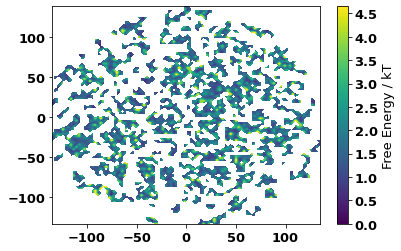

In [278]:
pca = np.load(f'{dimreduct_results_dir}/dimreduct_tSNE_xyz.npy')
pyemma.plots.plot_free_energy(pca[:, 0],pca[:, 1], cmap='viridis', cbar_label='Free Energy / kT' )

## RMSD map

In [139]:
plotting.RMSD_map(pca, 'dimreduct_kPCA_poly_xyz', ref_frame=87507)

Loading BokehJS ...

# [Clustering](pre_clustering_inspection.py)
Find out the optimal number of clusters for each algorithm (kMeans, kMedoids, GMM)

## Datasets used for clustering
- PCA
- PCA_xyz
- kPCA_poly
- kPCA_poly_xyz
- tSNE
- tSNE_xyz
- We didn't choose kPCA_rbf, since it is very similar to the poly kernel for our triad molecule

## Clustering methods
- kMeans
    - Set as default
    - n_clusters: 2-20
- kMedoids
    - init='k-medoids++'
    - Others set as default
    - n_clusters: 2-20
- GMM
    - n_init=10
    - Others set as default
    - n_components: 2-20
- HDBSCAN
    - Set as default
    - min_cluster_size: 10-100
    - min_samples: 1, 10, 100
    - cluster_selection_epsilon: 1, 10, 100, 500

## Inspection of clustering results

### Scoring (AIC, BIC, Inertia, Silhouette score)

In [11]:
importlib.reload(plotting)
x_axis = list(range(2,21,2))
save_dir = '/xspace/hl4212/results/clustering/plots/benchmarks'
plotting.preclustering_benchmark(x_axis, 'PCA_xyz', 'kmeans')

Loading BokehJS ...

### Benchmarks results
- kPCA_poly_gmm: 8 (6-8)
- kPCA_poly_kmeans: 6 (6-8)
- kPCA_poly_kmedoids: 8 (6-8)
- kPCA_poly_xyz_gmm: 10 (10-12)
- kPCA_poly_xyz_kmeans: 6 (6-8)
- kPCA_poly_xyz_kmedoids: 6 (6-8)
- PCA_gmm: 6 (6-8)
- PCA_kmeans: 8 (6-8)
- PCA_kmedoids: 6 (6-8)
- PCA_xyz_gmm: 10 (8-10)
- PCA_xyz_kmeans: 6 (6-8)
- PCA_xyz_kmedoids: 12 (8-12)
- tSNE_gmm: 10 (8-12)
- tSNE_kmeans: 6
- tSNE_kmedoids: 10 (8-10)
- tSNE_xyz_gmm: 12
- tSNE_xyz_kmeans: 6 (6-8)
- tSNE_xyz_kmedoids 6 (6-8)

### [RMSD within & between clusters](get_rmsd_map.py)

Pairwise RMSD on the 1000 nearest instances of each cluster center (result directory [here](http://localhost:8889/tree/results/clustering/plots/RMSD_map))

Better results:
- tSNE_xyz_kmedoids_8
- **tSNE_xyz_kmeans_7**
- **tSNE_xyz_gmm_6**
- tSNE_xyz_gmm_7
- PCA_xyz_kmedoids_8, 6
- PCA_xyz_kmeans_8
- PCA_xyz_kmeans_7
- PCA_xyz_gmm_8

### Cluster population
Assume a cluster should contain at least 5% of the total nunmber of instances

In [311]:
inspector = Cluster_inspection(100000, 'tSNE_xyz', 'gmm', 2)
inspector.cluster_population()

,cluster_idx,population,percentage
0,0,10689,10
1,1,12111,12
2,2,11902,11
3,3,10532,10
4,4,11296,11
5,5,14970,14
6,6,15175,15
7,7,13325,13


In [312]:
importlib.reload(plotting)
cluster_population(inspector.cluster_population())

### Pearson Correlation Coefficient between clusters

In [137]:
a = inspector.PearsonR(dim='dim1')
b = inspector.PearsonR(dim='dim2')

array([[ 1.00000000e+00, -9.10184532e-03,  1.88374554e-02,
        -2.01355874e-02,  1.65604692e-02,  2.60010799e-02,
         9.41269244e-02],
       [-9.10184532e-03,  1.00000000e+00, -1.12318004e-01,
        -4.23820315e-02, -4.90380520e-04,  7.56803606e-02,
         7.01226559e-02],
       [ 1.88374554e-02, -1.12318004e-01,  1.00000000e+00,
        -7.66236045e-02, -7.73611795e-02, -5.70420907e-02,
        -9.62257406e-02],
       [-2.01355874e-02, -4.23820315e-02, -7.66236045e-02,
         1.00000000e+00,  9.70085772e-02,  1.13133726e-02,
        -1.31437637e-02],
       [ 1.65604692e-02, -4.90380520e-04, -7.73611795e-02,
         9.70085772e-02,  1.00000000e+00,  1.44342286e-02,
         2.56663773e-02],
       [ 2.60010799e-02,  7.56803606e-02, -5.70420907e-02,
         1.13133726e-02,  1.44342286e-02,  1.00000000e+00,
         1.92382415e-02],
       [ 9.41269244e-02,  7.01226559e-02, -9.62257406e-02,
        -1.31437637e-02,  2.56663773e-02,  1.92382415e-02,
         1.0000000

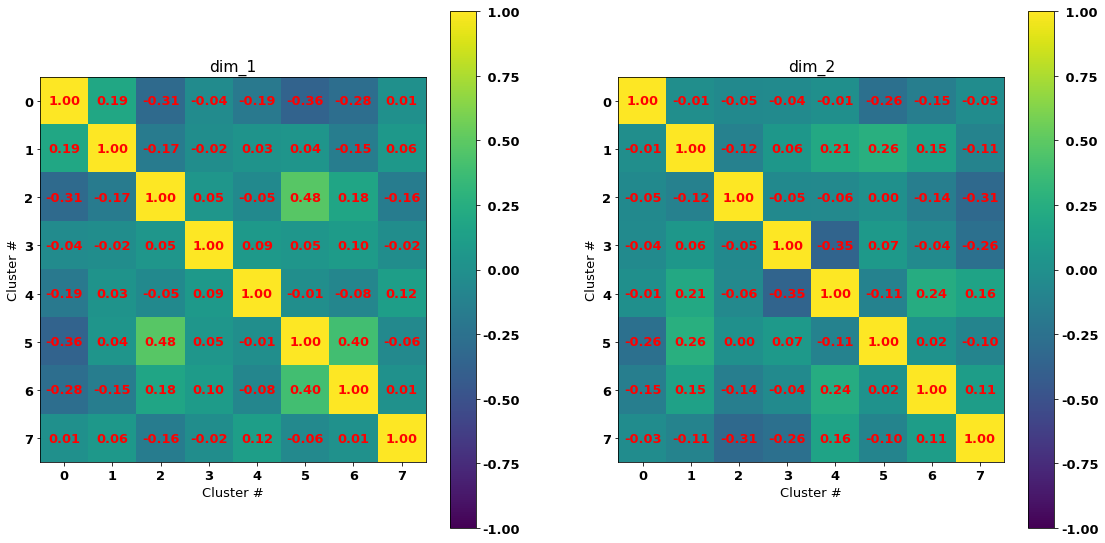

In [314]:
importlib.reload(plotting)
plotting.PearsonR_heatmap(a, b)

### Structures of core instances

In [125]:
inspector = Cluster_inspection(100000, 'PCA_xyz', 'kmedoids', 1)
medoids_arr = inspector.find_nearest_n(100)#.reshape(-1,)
triad_viz = Visualization(traj_path_aligned, top_path)

In [131]:
triad_viz.compare(medoids_arr[3][16], medoids_arr[3][78])

NGLWidget()

### Cluster centers & clusters

In [135]:
importlib.reload(plotting)
#save_dir = '/xspace/hl4212/results/clustering/plots/cluster_map'
plotting.cluster_map(100000, 'PCA_xyz', 'kmeans',1)

Loading BokehJS ...

## [Clustering on high dimensional space](http://localhost:8889/edit/durf_hq/projects/Gustave_Li/Main_program/high_dim_clustering.py)

After finding cluster centers in feature space (2D) with different dimensionality reduction & clustering methods, we would like to go back to high dimensional space (original xyz space) to find members of each cluster, since information is more completely preserved in a higher space.

We use RMSD to determine the membership, i.e., a triad molecule that has RMSD smaller than a given threshold, with respect to a cluster center, will be regarded as a member of that cluster.

Results are stored in [this folder](http://localhost:8889/tree/results/high_dim_clustering)

In [31]:
results_dir = '/xspace/hl4212/results/high_dim_clustering'
b = np.load(f'{results_dir}/PCA_xyz_kmeans_2_0.3_Labels.npy')

In [33]:
np.unique(b, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7]),
 array([64671,  2863,   517,  3201, 16424,   688,  3043,  4026,  4567]))